In [1]:
import numpy as np
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter
from skimage.color import rgb2hsv, hsv2rgb

In [2]:
def gauss_(s, k_pyr):
    n, m = s.shape
    s_new = np.zeros((n+2, m+2))
    s_new[1:-1, 1:-1] = s
    s_new[0, 1:-1] = s[0,:]
    s_new[-1, 1:-1] = s[-1, :]
    s_new[1:-1,0] = s[:,0]
    s_new[1:-1,-1] = s[:,-1]
    s_nxt = np.zeros((n, m))
#     print(s_new)
    
    for i in range(n):
        for j in range(m):
            s_nxt[i,j] = np.sum(s_new[i:i+3,j:j+3] * k_pyr)
#             print(i, j, s_nxt[i,j])
            
    return s_nxt


def gauss(s, k_pyr):
    n, m = s.shape
    s_nxt = np.zeros((n-2, m-2))
    
    for i in range(n-2):
        for j in range(m-2):
            s_nxt[i,j] = np.sum(s[i:i+3,j:j+3] * k_pyr)
            
    return s_nxt

def gauss_kernal(shape):
    # k_pyr = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) /16
    k = cv2.getGaussianKernel(shape, 0)
    k = k*k.T
    return k


In [3]:
def up_scale(l):
    n, m = l.shape

    ind_x = np.tile(np.arange(n), (m, 1)).T *2
    ind_y = np.tile(np.arange(m), (n, 1)) *2
    out = np.zeros((2*n, 2*m))

    out[ind_x, ind_y] = l
    out[ind_x+1, ind_y] = l
    out[ind_x, ind_y+1] = l
    out[ind_x+1, ind_y+1] = l

    return out

In [4]:
def gauss(s, k_pyr):
    n, m = s.shape
#     s_new = np.zeros((n+2, m+2))
#     s_new[1:-1, 1:-1] = s
#     s_new[0, 1:-1] = s[0,:]
#     s_new[-1, 1:-1] = s[-1, :]
#     s_new[1:-1:0] = s[:,0]
#     s_new[1:-1:-1] = s[:,-1]
    s_nxt = np.zeros((n-2, m-2))
#     print(s_new)
    
    for i in range(n-2):
        for j in range(m-2):
            s_nxt[i,j] = np.sum(s[i:i+3,j:j+3] * k_pyr)
#             print(i, j, s_nxt[i,j])
            
    return s_nxt

In [5]:
def decimate(s):
    n, m  = s.shape
    ind_x = np.tile(np.arange(0, n, 2), (int((m+1)/2),1)).T
    ind_y = np.tile(np.arange(0, m, 2), (int((n+1)/2),1))
#     print(ind_x)
#     print(ind_y)
    
    return s[ind_x, ind_y]
    

In [6]:
def num_laplace(G, k):
    return cv2.Laplacian(G, cv2.CV_64F) * 2**(-2*(k-1))
    
#     return cv2.Laplacian(G, ddepth=cv2.CV_64F,ksize=3) #* 2**(-2*(k-1))

In [7]:
def lin_scale(arr, min_act, max_act, min_val, max_val):
    if min_act is None or max_act is None:
        min_act, max_act = np.min(arr), np.max(arr)
        
    m_ = (max_val-max_act)/(min_val-min_act)
    c_ = min_val - m_*min_act
    arr_new = m_*arr + c_
    
    arr_new = np.clip(arr_new, min_val, max_val)

    min1, max1 = np.min(arr), np.max(arr)
    min2, max2 = np.min(arr_new), np.max(arr_new)
    
    print("(%.2f, %.2f) --> (%.2f, %.2f)" %(min1, max1, min2, max2))

    return arr_new

In [8]:
def gamma_correction(S, L, R, gamma, max_val):
    """
    max_val = limit of S (255)
    """

    W = np.ones(S.shape) * max_val
    L_ = W * np.power((L/W), 1/gamma)
    S_ = L_ * R
    
    return S_
    
    

In [9]:
def rgb_enhance(S,  min_act, max_act, a = .1, b = 1000, min_val=1, max_val=1000, gamma = 3, show = False):
    """ scale to correct 0 errror in log scale"""
    S_mod = S.astype(np.float64)
    
    assert min_val >= 1,  "Error : Minimum value must be more than 1 to avoid log inf error"

    S_mod = lin_scale(S_mod, min_act, max_act, min_val, max_val)
    
    if show:
        cv2.imshow('S_mod', S_mod/max_val)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    height, width, channels = S_mod.shape

    R = np.zeros(S.shape)
    L = np.zeros(S.shape)

    p = math.floor(np.log2(min(height, width)))

    for c_ in range(channels):
        s_ori = np.log(S_mod[:, :, c_])

        # S_ = np.exp(s_ori)
        # cv2.imshow('im3', S_/255)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        s_pyr = {}

        s_pyr[1] = s_ori

        for i in range(1, p):
            s = s_pyr[i]
            s_nxt = cv2.GaussianBlur(s , (3, 3), 0)
            s_pyr[i+1] = decimate(s_nxt)

        k = p


        l = {}

        # l[0] = s_pyr[p]
        l[0] = np.array(np.max(s_pyr[p])).reshape((1, 1))

        Tk = 10

        while k > 0:

            # print("K", k, s_pyr[k].shape, l[0].shape, np.max(s_pyr[k]), np.max(l[0]))

            # print(s_pyr[k])
            # UPSAMPLE error
            if (s_pyr[k].shape[0] < l[0].shape[0]):
                l[0] = l[0][:-1, :]
            if (s_pyr[k].shape[1] < l[0].shape[1]):
                l[0] = l[0][:, :-1]

            Gb = num_laplace(s_pyr[k], k)

            print("K", k, Gb.shape, s_pyr[k].shape, l[0].shape)
            # print(l)

            for j in range(1, Tk+1):

                Ga = num_laplace(l[j-1], k)
                # print(Ga.shape, Gb.shape, s_pyr[k].shape)

                G = Ga + a*(l[j-1]-s_pyr[k]) - b*(Ga-Gb)
                # print(G.shape)
                # print(np.max(G),np.max(Ga), np.max(Gb))

                u_a = np.sum(G*G)

                u_b = -1* np.sum(G * num_laplace(G, k))

                u_NSD = u_a/(a*u_a + (1+b)*u_b)
                # print("u_NDS", u_NSD)

                l[j] = l[j-1] -u_NSD*G
                # print(l[j].shape)

                l[j] = np.maximum(s_pyr[k], l[j])

                # print ("J", j, Ga.shape, u_a.shape, u_b.shape, l[j].shape)

            out = l[Tk]
            l = {}
            l[0] = up_scale(out)
            # print()


            k-= 1

        # print (out.shape)

        ill = out
        ill_mod = np.clip(ill, a_min = 0, a_max = 100)

        ref = s_ori - ill

        L[:,:,c_] = np.exp(ill_mod)
        R[:,:,c_] = np.exp(ref)


    """ Gamma correction """
    
    S_ = gamma_correction(S_mod, L, R, gamma, max_val)
    
    if show:
        sns.distplot(S_.flatten(),  bins=100)
        plt.show()
    
    """
    R : Reflectence (0 <= R <= 1)
    S_ : Gamma corrected output (min_val <= S_ <= max_val)
    """
    return R, S_
        

#     S = S.astype(np.uint8)
#     S_ = S_.astype(np.uint8)
#     R = (R*255).astype(np.uint8)


<h2> Main

In [13]:
im_name = "r0b03e77at.png"

cwd = os.getcwd()
file_low = 'im_low.png'
file_high = 'im_high.png'

rgb_img = cv2.imread(file_low)
cv2.imshow('im_rgb', rgb_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

min_rgb, max_rgb = np.min(rgb_img), np.max(rgb_img)
print("%.2f | %.2f" %(min_rgb, max_rgb))


0.00 | 255.00


In [14]:
hsv_img = rgb2hsv(rgb_img)
cv2.imshow('im_hsv', hsv_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

min_hsv, max_hsv = np.min(hsv_img), np.max(hsv_img)
print("%.2f | %.2f" %(min_hsv, max_hsv))


0.00 | 1.00


In [48]:
"""Consider only V of HSV"""
S = np.array(hsv_img[:, :, 2], copy=True)

S_mod = S.astype(np.float64)
S_mod = lin_scale(S_mod, np.min(S_mod), np.max(S_mod), 1, 255)

cv2.imshow('im2', S_mod/np.max(S_mod))
cv2.waitKey(0)
cv2.destroyAllWindows()

(0.00, 1.00) --> (1.00, 255.00)


In [49]:
s_ori = np.log(S_mod)

# S_ = np.exp(s_ori)
# cv2.imshow('im3', S_/255)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


p = 9

s_pyr = {}

s_pyr[1] = s_ori

for i in range(1, p):
    s = s_pyr[i]
    s_nxt = cv2.GaussianBlur(s , (3, 3), 0)
    s_pyr[i+1] = decimate(s_nxt)

for i in s_pyr:
    print(i, s_pyr[i].shape)
    

1 (384, 384)
2 (192, 192)
3 (96, 96)
4 (48, 48)
5 (24, 24)
6 (12, 12)
7 (6, 6)
8 (3, 3)
9 (2, 2)


In [50]:
for i in range(1, p+1):
    S_pyr = np.exp(s_pyr[i])
    for i in range(i-1):
        S_pyr = up_scale(S_pyr)
    cv2.imshow('im3', S_pyr/255)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [51]:
k = p

# a = .1
# b = 1000
a = .1
b = 1000

l = {}

l[0] = s_pyr[p]
# l[0] = np.array(np.max(s_pyr[p])).reshape((1, 1))

Tk = 10


while k > 0:

    print("K", k, s_pyr[k].shape, l[0].shape, np.max(s_pyr[k]), np.max(l[0]))

    # print(s_pyr[k])
    # UPSAMPLE error
    if (s_pyr[k].shape[0] < l[0].shape[0]):
        l[0] = l[0][:-1, :]
    if (s_pyr[k].shape[1] < l[0].shape[1]):
        l[0] = l[0][:, :-1]


    Gb = num_laplace(s_pyr[k], k)

#     print("K", k, Gb.shape, s_pyr[k].shape, l[0].shape)
    # print(l)

    for j in range(1, Tk+1):
        
        Ga = num_laplace(l[j-1], k)
        # print(Ga.shape, Gb.shape, s_pyr[k].shape)
        
        G = Ga + a*(l[j-1]-s_pyr[k]) - b*(Ga-Gb)
        # print(G.shape)
#         print("max_G %f | max_ga %f | max_Gb %f " %(np.max(G),np.max(Ga), np.max(Gb)))

        u_a = np.sum(G*G)

        u_b = -1* np.sum(G * num_laplace(G, k))

        u_NSD = u_a/(a*u_a + (1+b)*u_b)
#         print("u_NDS", u_NSD)

        l[j] = l[j-1] -u_NSD*G
    #     print(l[j].shape)

        l[j] = np.maximum(s_pyr[k], l[j])

#         print ("J", j, Ga.shape, u_a.shape, u_b.shape, l[j].shape)
    
    out = l[Tk]
    l = {}
    l[0] = up_scale(out)
    print()
    
    
    k-= 1
    
print (out.shape)

K 9 (2, 2) (2, 2) 4.440916426596355 4.440916426596355

K 8 (3, 3) (4, 4) 5.020446797293738 4.441250166176065

K 7 (6, 6) (6, 6) 5.1466300068612085 5.029019448721491

K 6 (12, 12) (12, 12) 5.227815380164797 5.213913559835328

K 5 (24, 24) (24, 24) 5.394763956109282 5.338957826993483

K 4 (48, 48) (48, 48) 5.51580146835089 5.509019862623586

K 3 (96, 96) (96, 96) 5.539438869849597 5.673209915768462

K 2 (192, 192) (192, 192) 5.541263545158426 5.8231838995926095

K 1 (384, 384) (384, 384) 5.541263545158426 5.940195582945752

(384, 384)


In [52]:
ill = out
ill_mod = np.clip(ill, a_min = 0, a_max = 100)

ref = s_ori - ill

R = np.exp(ref)

0.7858137558217497
3.492819109493516


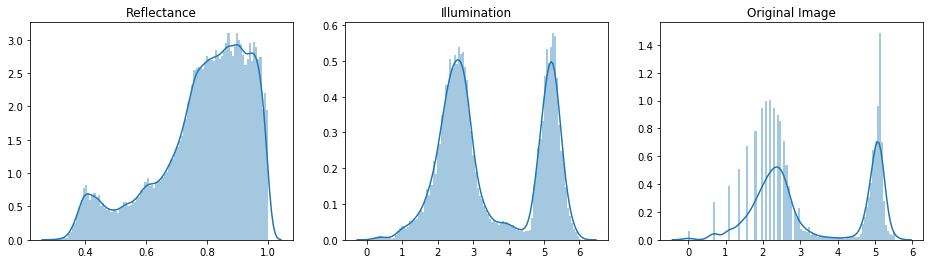

In [53]:

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 4))

sns.distplot(R.flatten(),  bins=100, ax=ax0)
ax0.set_title("Reflectance")
# ax0.axis('off')

sns.distplot(ill_mod.flatten(),  bins=100, ax=ax1)
ax1.set_title("Illumination")
# ax1.axis('off')

sns.distplot(s_ori.flatten(),  bins=100, ax=ax2)
ax2.set_title("Original Image")
# ax2.axis('off')

# sns.distplot(ill_mod.flatten(),  bins=100, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
print(np.mean(R))
print(np.mean(ill_mod))

In [54]:
cv2.imshow('ref', R)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [55]:
gamma = 4


L = np.exp(ill_mod)

S = np.exp(s_ori)

R = np.exp(ref)

W = np.ones(S.shape) * 255

L_ = W * np.power((L/W), 1/gamma)

# S_ = (L_/L) * S

S_ = L_ * R

Text(0.5, 1.0, 'Gamma corrected')

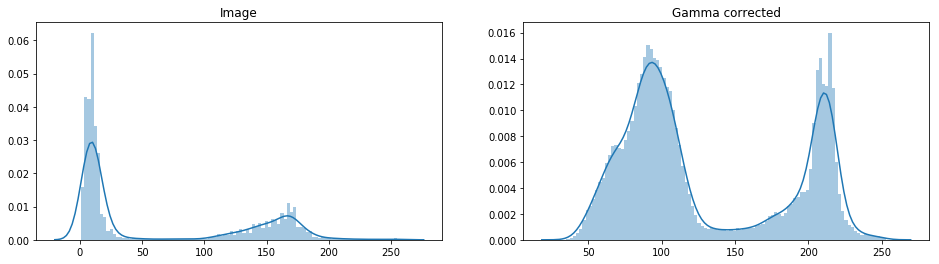

In [56]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 4))

sns.distplot(S.flatten(),  bins=100, ax=ax0)
ax0.set_title("Image")

sns.distplot(S_.flatten(),  bins=100, ax=ax1)
ax1.set_title("Gamma corrected")


In [73]:
cv2.imshow('orig', S/255)
cv2.waitKey(0)
cv2.destroyAllWindows()

cv2.imshow('GC', S_/255)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [74]:
hsv_new = np.array(hsv_img, copy = True)

hsv_new[:, :, 2] = np.array(S_,copy=True)/255#.astype(np.uint8)

# np.max(hsv_new)

In [75]:
rgb_new = (hsv2rgb(hsv_new)*255).astype(np.uint8)

rgb_new.dtype

dtype('uint8')

(-0.5, 383.5, 383.5, -0.5)

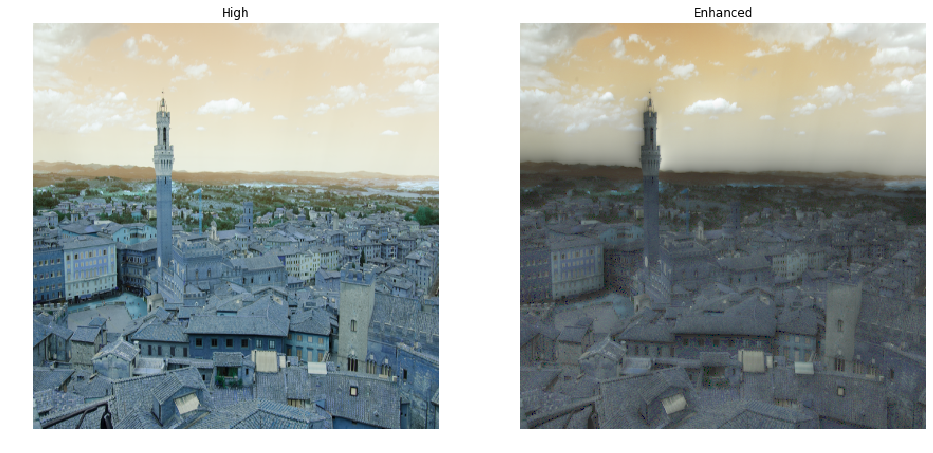

In [78]:
img_high = cv2.imread(file_high)

# res = np.hstack(rgb_new, img_high)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 10))

ax0.imshow(img_high)
ax0.set_title("High")
ax0.axis('off')
ax1.imshow(rgb_new)
ax1.set_title("Enhanced")
ax1.axis('off')



# cv2.imshow('GC_hsv', rgb_new)

# cv2.imshow('img_original', img_high)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


<h2> Main 2

In [8]:
im_name = "r0b03e77at.png"

cwd = os.getcwd()
file_low = cwd + "/my_dataset/low/" + im_name
file_high = cwd + "/my_dataset/high/" + im_name

rgb_img = cv2.imread(file_low)
cv2.imshow('im_rgb', rgb_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

min_rgb, max_rgb = np.min(rgb_img), np.max(rgb_img)
print("[%.2f , %.2f]" %(min_rgb, max_rgb))


[0.00 , 255.00]


In [ ]:
R, S_ = rgb_enhance(S,  min_act, max_act)